In [1]:
!pip install pafy youtube-dl moviepy

     |████████████████████████████████| 1.9 MB 11.0 MB/s 


In [2]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3137536/45929032 bytes (6.8%)6733824/45929032 bytes (14.7%)10182656/45929032 bytes (22.2%)13672448/45929032 bytes (29.8%)17211392/45929032 bytes (37.5%)20398080/45929032 bytes (44.4%)23945216/45929032 bytes (52.1%)27205632/45929032 bytes (59.2%)30908416/45929032 bytes (67.3%)34242560/45929032 bytes (74.6%)36773888/45929032 bytes (80.1%)39378944/45929032 bytes (85.7%)

In [3]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y


--2022-05-13 12:20:04--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  46.5MB/s    in 67s     

2022-05-13 12:21:12 (45.8 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



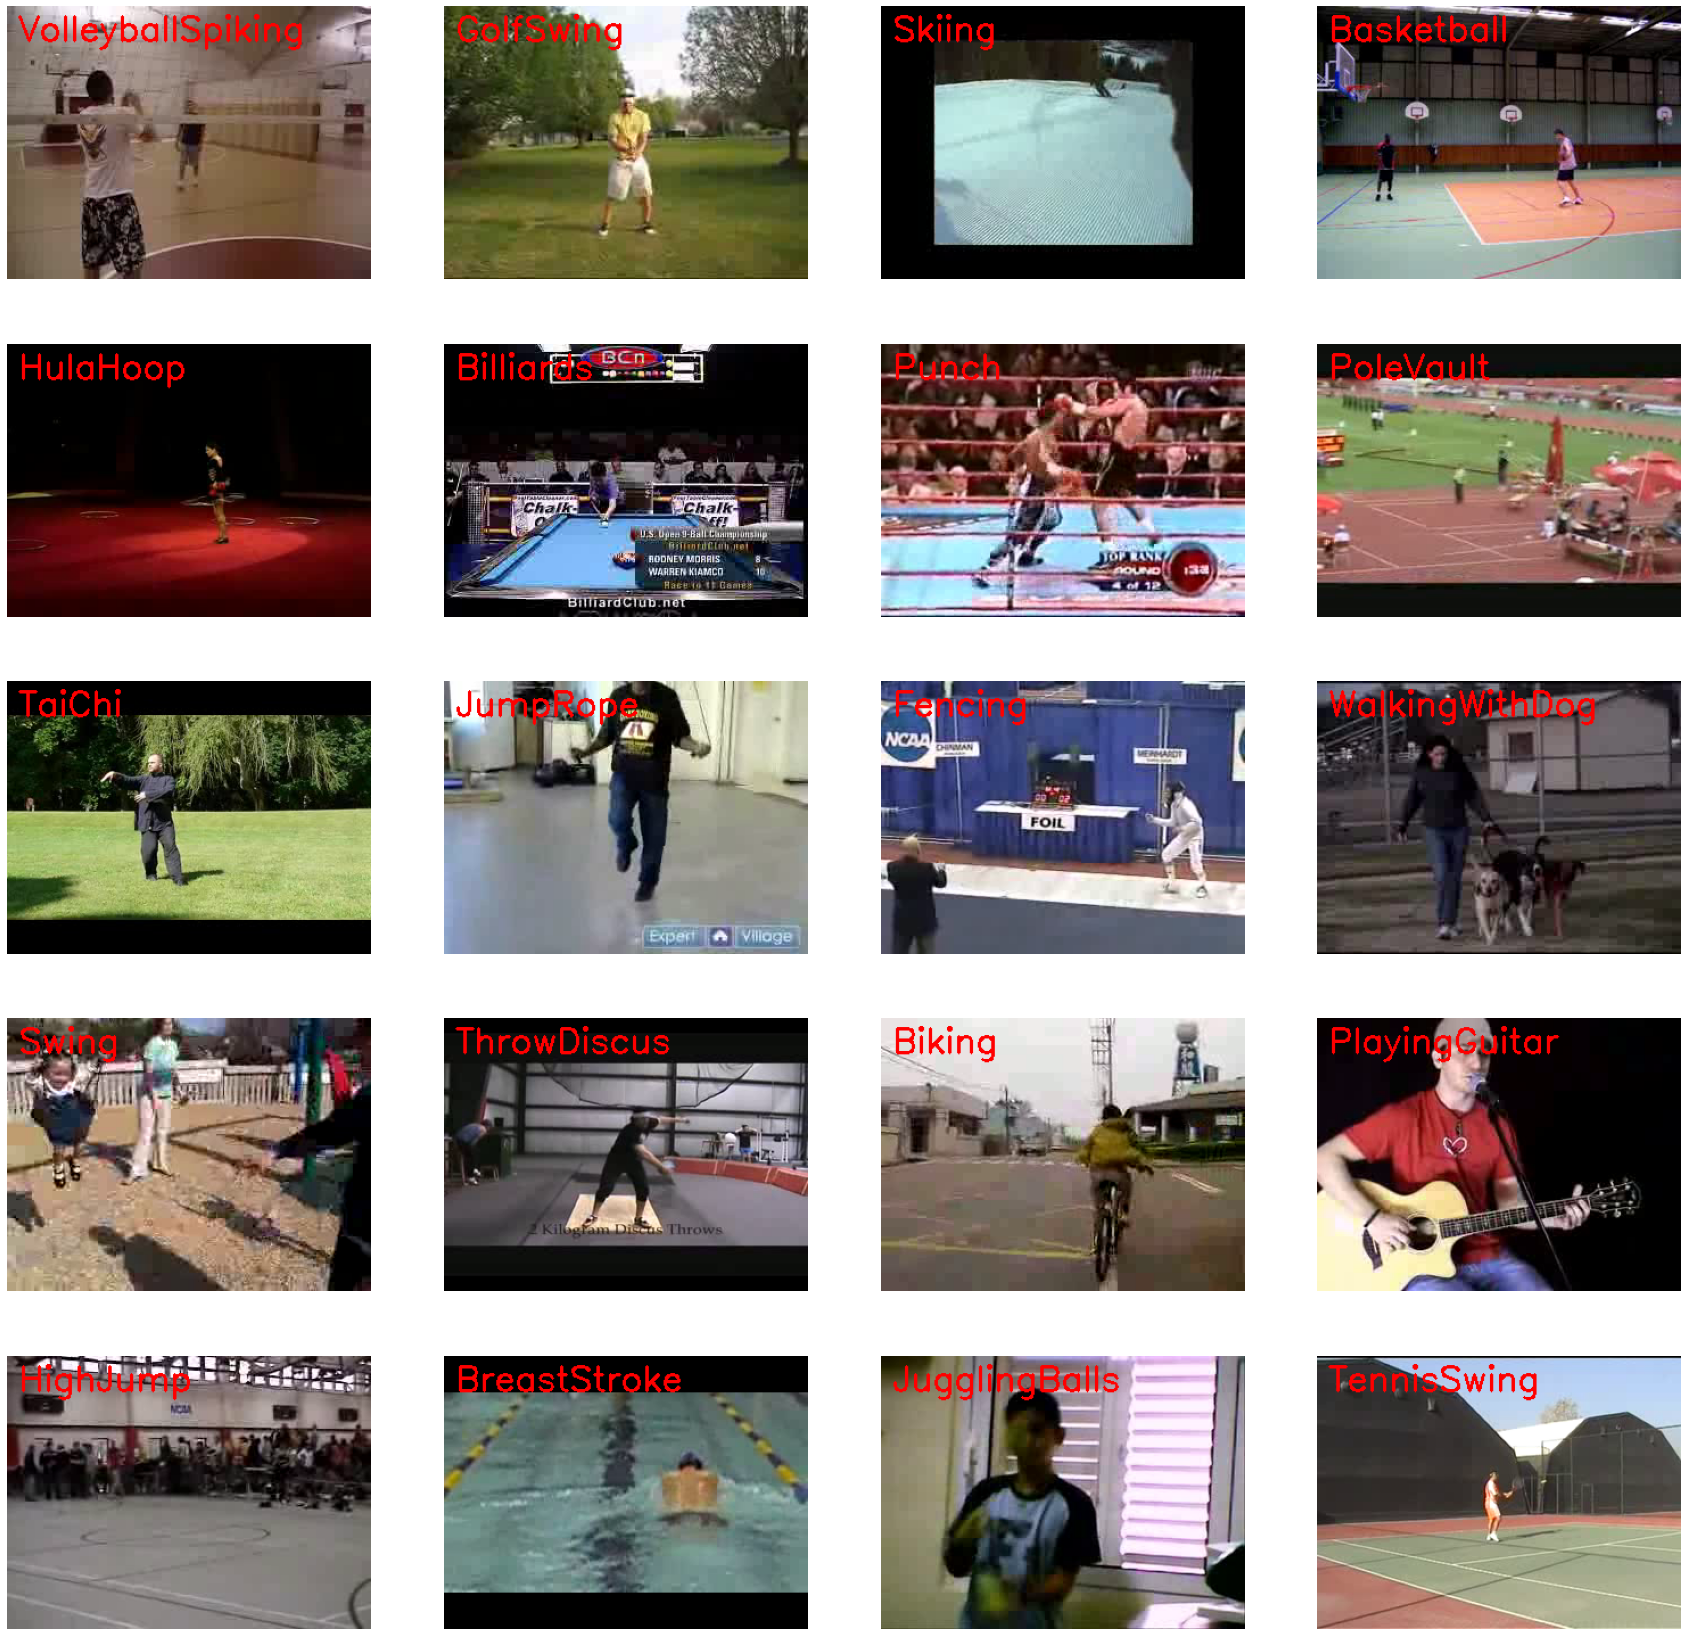

In [5]:
plt.figure(figsize = (30, 30))
all_classes_names = os.listdir('UCF50')
random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [6]:
image_height, image_width = 64, 64
max_images_per_class = 8000

dataset_directory = "UCF50"
classes_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

model_output_size = len(classes_list)

In [7]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    while True:
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (image_height, image_width))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

In [8]:
def create_dataset():
    temp_features = [] 
    features = []
    labels = []
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
            frames = frames_extraction(video_file_path)
            temp_features.extend(frames)
        features.extend(random.sample(temp_features, max_images_per_class))
        labels.extend([class_index] * max_images_per_class)
        temp_features.clear()
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [9]:
features, labels = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [10]:
one_hot_encoded_labels = to_categorical(labels)

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [12]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))
    model.summary()

    return model

model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

In [13]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

In [14]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [15]:
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
5120/5120 [==============================] - 577s 113ms/step - loss: 0.9006 - accuracy: 0.6336 - val_loss: 0.8711 - val_accuracy: 0.7424
Epoch 2/50
5120/5120 [==============================] - 576s 112ms/step - loss: 0.5458 - accuracy: 0.7996 - val_loss: 2.1519 - val_accuracy: 0.5926
Epoch 3/50
5120/5120 [==============================] - 582s 114ms/step - loss: 0.4119 - accuracy: 0.8516 - val_loss: 0.3720 - val_accuracy: 0.9514
Epoch 4/50
5120/5120 [==============================] - 589s 115ms/step - loss: 0.3362 - accuracy: 0.8813 - val_loss: 0.9261 - val_accuracy: 0.8402
Epoch 5/50
5120/5120 [==============================] - 590s 115ms/step - loss: 0.2996 - accuracy: 0.8980 - val_loss: 1.0448 - val_accuracy: 0.9154
Epoch 6/50
5120/5120 [==============================] - 589s 115ms/step - loss: 0.2718 - accuracy: 0.9073 - val_loss: 0.3655 - val_accuracy: 0.9617
Epoch 7/50
5120/5120 [==============================] - 591s 115ms/step - loss: 0.2616 - accuracy: 0.9133 - val_

In [16]:
model_evaluation_history = model.evaluate(features_test, labels_test)

200/200 [==============================] - 39s 192ms/step - loss: 0.0278 - accuracy: 0.9908


In [17]:
model.save("VideoClassifierModel")

In [ ]:
model = tf.keras.models.load_model('VideoClassifierModel.h5')
output_directory = 'Youtube_Videos'

In [ ]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)
    video_reader = cv2.VideoCapture(video_file_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = video_frames_count // predictions_frames_count
    for frame_counter in range(predictions_frames_count): 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        _ , frame = video_reader.read() 
        resized_frame = cv2.resize(frame, (image_height, image_width))
        normalized_frame = resized_frame / 255
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:
        predicted_class_name = classes_list[predicted_label]
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]
        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability*100):.2}")
    video_reader.release()